In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential, load_model, save_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('Data/energydata_complete.csv',index_col=0,parse_dates=True,infer_datetime_format=True)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
df.shape

(19735, 28)

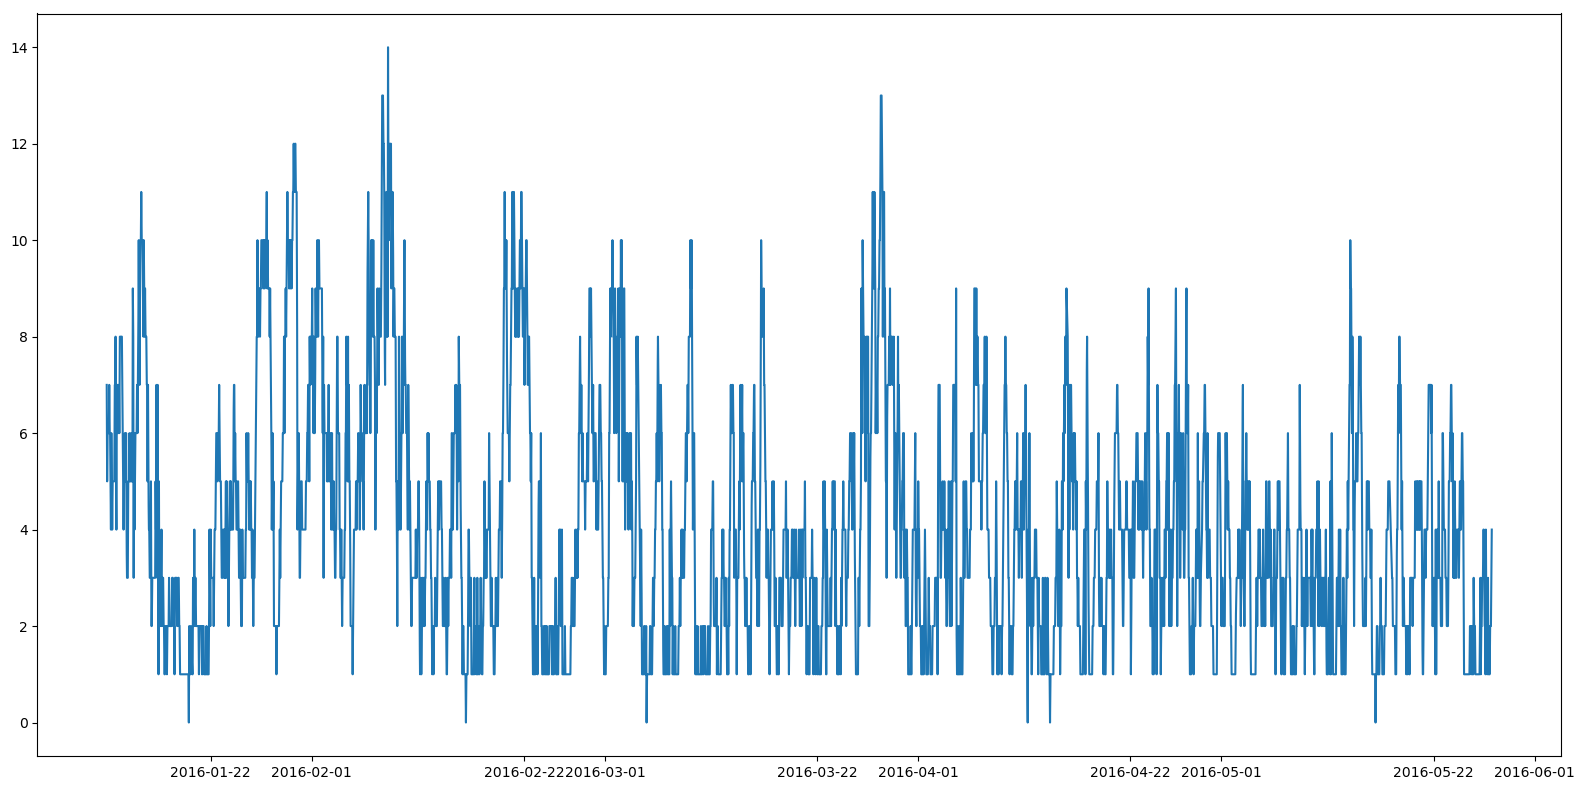

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df['Windspeed'])
plt.tight_layout();

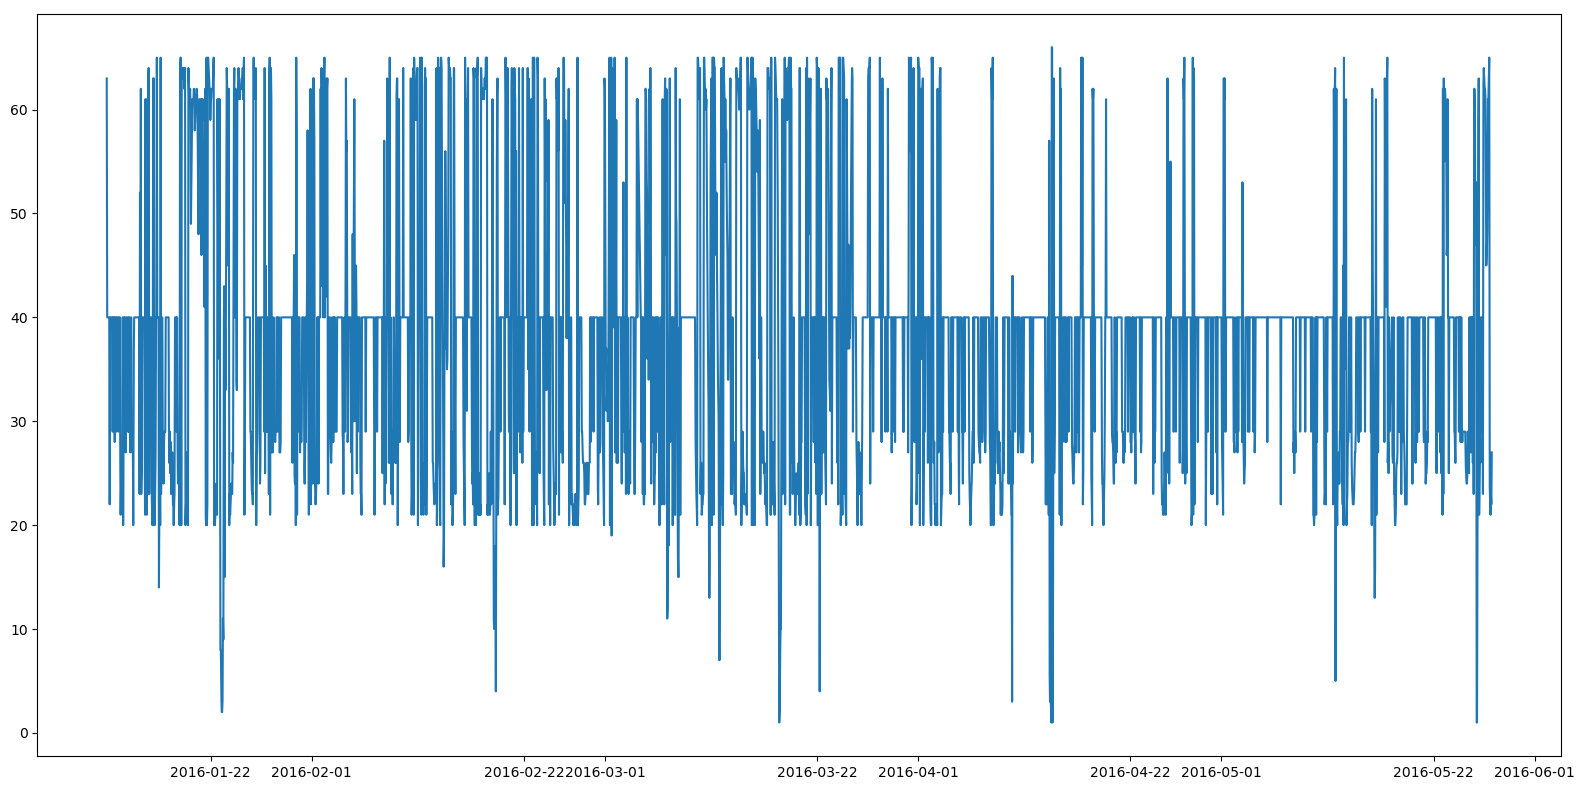

In [7]:
plt.figure(figsize=(16,8))
plt.plot(df['Visibility'])
plt.tight_layout();

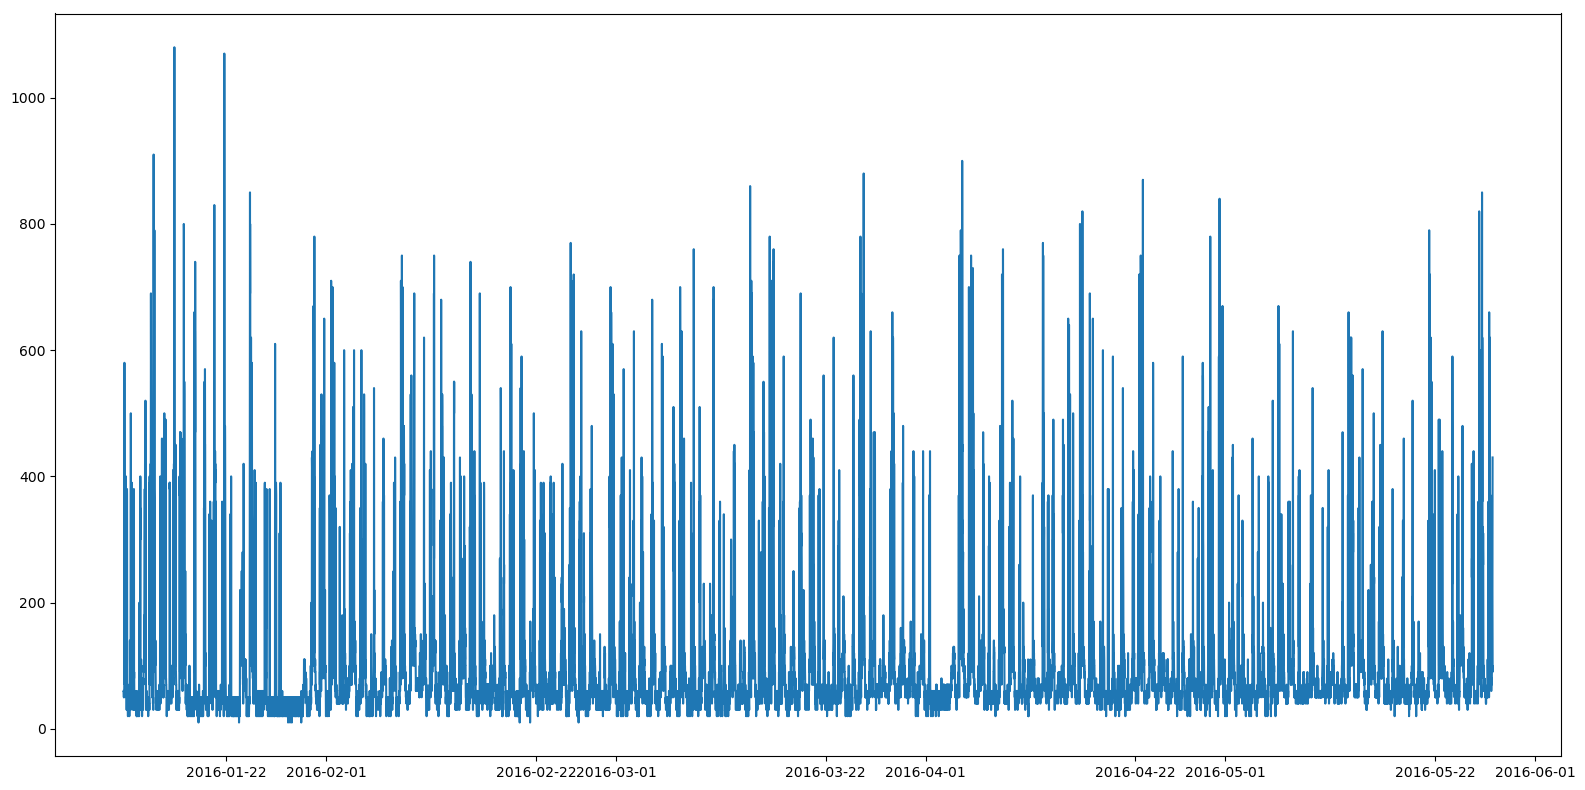

In [8]:
plt.figure(figsize=(16,8))
plt.plot(df['Appliances'])
plt.tight_layout();

In [9]:
df.index

DatetimeIndex(['2016-01-11 17:00:00', '2016-01-11 17:10:00',
               '2016-01-11 17:20:00', '2016-01-11 17:30:00',
               '2016-01-11 17:40:00', '2016-01-11 17:50:00',
               '2016-01-11 18:00:00', '2016-01-11 18:10:00',
               '2016-01-11 18:20:00', '2016-01-11 18:30:00',
               ...
               '2016-05-27 16:30:00', '2016-05-27 16:40:00',
               '2016-05-27 16:50:00', '2016-05-27 17:00:00',
               '2016-05-27 17:10:00', '2016-05-27 17:20:00',
               '2016-05-27 17:30:00', '2016-05-27 17:40:00',
               '2016-05-27 17:50:00', '2016-05-27 18:00:00'],
              dtype='datetime64[ns]', name='date', length=19735, freq=None)

In [10]:
len(df)

19735

In [37]:
df = df.round(2)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.60,19.2,44.79,19.79,44.73,19.00,45.57,...,17.03,45.53,6.60,733.5,92.0,7.00,63.00,5.3,13.28,13.28
2016-01-11 17:10:00,60,30,19.89,46.69,19.2,44.72,19.79,44.79,19.00,45.99,...,17.07,45.56,6.48,733.6,92.0,6.67,59.17,5.2,18.61,18.61
2016-01-11 17:20:00,50,30,19.89,46.30,19.2,44.63,19.79,44.93,18.93,45.89,...,17.00,45.50,6.37,733.7,92.0,6.33,55.33,5.1,28.64,28.64
2016-01-11 17:30:00,50,40,19.89,46.07,19.2,44.59,19.79,45.00,18.89,45.72,...,17.00,45.40,6.25,733.8,92.0,6.00,51.50,5.0,45.41,45.41
2016-01-11 17:40:00,60,40,19.89,46.33,19.2,44.53,19.79,45.00,18.89,45.53,...,17.00,45.40,6.13,733.9,92.0,5.67,47.67,4.9,10.08,10.08


In [38]:
# How many rows cover 1 day? As data is recorded every 10 min
no_rows = 24 * 60//10
no_rows

144

In [39]:
test_days = 30
test_size = test_days * no_rows
test_size

4320

In [40]:
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

In [41]:
train.shape, test.shape

((15415, 28), (4320, 28))

In [42]:
train.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.60,19.2,44.79,19.79,44.73,19.00,45.57,...,17.03,45.53,6.60,733.5,92.0,7.00,63.00,5.3,13.28,13.28
2016-01-11 17:10:00,60,30,19.89,46.69,19.2,44.72,19.79,44.79,19.00,45.99,...,17.07,45.56,6.48,733.6,92.0,6.67,59.17,5.2,18.61,18.61
2016-01-11 17:20:00,50,30,19.89,46.30,19.2,44.63,19.79,44.93,18.93,45.89,...,17.00,45.50,6.37,733.7,92.0,6.33,55.33,5.1,28.64,28.64
2016-01-11 17:30:00,50,40,19.89,46.07,19.2,44.59,19.79,45.00,18.89,45.72,...,17.00,45.40,6.25,733.8,92.0,6.00,51.50,5.0,45.41,45.41
2016-01-11 17:40:00,60,40,19.89,46.33,19.2,44.53,19.79,45.00,18.89,45.53,...,17.00,45.40,6.13,733.9,92.0,5.67,47.67,4.9,10.08,10.08


In [43]:
test.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-04-27 18:10:00,180,0,21.26,37.43,19.57,35.40,21.29,34.06,20.29,33.76,...,19.1,32.70,7.22,753.87,62.67,3.0,40.0,0.45,4.37,4.37
2016-04-27 18:20:00,100,0,21.43,41.73,19.70,35.83,21.32,34.50,20.29,34.10,...,19.1,32.70,7.43,753.93,62.33,3.0,40.0,0.60,39.44,39.44
2016-04-27 18:30:00,100,10,21.58,39.80,19.76,36.22,21.39,34.90,20.29,34.49,...,19.1,32.70,7.65,754.00,62.00,3.0,40.0,0.75,44.41,44.41
2016-04-27 18:40:00,100,0,21.67,37.53,19.89,36.50,21.50,35.06,20.29,34.73,...,19.1,32.70,7.87,754.07,61.67,3.0,40.0,0.90,27.38,27.38
2016-04-27 18:50:00,140,0,21.73,36.56,19.89,36.43,21.50,35.00,20.29,34.79,...,19.1,33.03,8.08,754.13,61.33,3.0,40.0,1.05,42.75,42.75


In [44]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [45]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [46]:
scaled_train[:5]

array([[0.04672897, 0.42857143, 0.42407661, 0.55767612, 0.36470588,
        0.62867526, 0.24903846, 0.69024529, 0.45034642, 0.76440461,
        0.2408377 , 0.32545932, 0.4786106 , 0.84186047, 0.22127139,
        0.6535461 , 0.21259843, 0.66141193, 0.23910615, 0.65022422,
        0.46963563, 0.09767442, 0.88405797, 0.5       , 0.95384615,
        0.66111111, 0.26545309, 0.26545309],
       [0.04672897, 0.42857143, 0.42407661, 0.53213584, 0.36470588,
        0.62636274, 0.24903846, 0.693668  , 0.45034642, 0.78233035,
        0.2408377 , 0.32545932, 0.47129799, 0.83983822, 0.22127139,
        0.65106383, 0.21259843, 0.66004112, 0.24357542, 0.65156951,
        0.46477733, 0.1       , 0.88405797, 0.47642857, 0.89492308,
        0.65555556, 0.37207441, 0.37207441],
       [0.03738318, 0.42857143, 0.42407661, 0.52119001, 0.36470588,
        0.62338949, 0.24903846, 0.70165431, 0.44226328, 0.77806231,
        0.2408377 , 0.32365486, 0.46142596, 0.83073812, 0.22127139,
        0.6464539 , 0.2125

In [47]:
scaled_test[:5]

array([[0.1588785 , 0.        , 0.61149111, 0.27224249, 0.40823529,
        0.31846713, 0.39326923, 0.08157444, 0.59930716, 0.26034998,
        0.48036649, 0.07447507, 0.44680073, 0.38614762, 0.52689487,
        0.18404255, 0.71878515, 0.32659356, 0.47039106, 0.07488789,
        0.49473684, 0.57139535, 0.45898551, 0.21428571, 0.6       ,
        0.39166667, 0.08721744, 0.08721744],
       [0.08411215, 0.        , 0.63474692, 0.39292731, 0.42352941,
        0.33267261, 0.39615385, 0.10667427, 0.59930716, 0.27486129,
        0.48036649, 0.07660761, 0.44424132, 0.3942366 , 0.52689487,
        0.18404255, 0.71878515, 0.33927347, 0.47039106, 0.07488789,
        0.50323887, 0.5727907 , 0.45405797, 0.21428571, 0.6       ,
        0.4       , 0.78875775, 0.78875775],
       [0.08411215, 0.14285714, 0.65526676, 0.33875947, 0.43058824,
        0.34555666, 0.40288462, 0.1294923 , 0.59930716, 0.29150662,
        0.48036649, 0.07988845, 0.44424132, 0.40040445, 0.52322738,
        0.18404255, 0.7232

In [109]:
n_inputs = 288
n_features = scaled_train.shape[1]

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_inputs,batch_size=8)
train_generator

In [110]:
X, y = train_generator[0]
X[:2]

array([[[0.04672897, 0.42857143, 0.42407661, ..., 0.66111111,
         0.26545309, 0.26545309],
        [0.04672897, 0.42857143, 0.42407661, ..., 0.65555556,
         0.37207441, 0.37207441],
        [0.03738318, 0.42857143, 0.42407661, ..., 0.65      ,
         0.57271454, 0.57271454],
        ...,
        [0.06542056, 0.        , 0.35567715, ..., 0.36666667,
         0.13842769, 0.13842769],
        [0.06542056, 0.        , 0.34610123, ..., 0.36833333,
         0.32126425, 0.32126425],
        [0.08411215, 0.        , 0.35567715, ..., 0.37055556,
         0.15463093, 0.15463093]],

       [[0.04672897, 0.42857143, 0.42407661, ..., 0.65555556,
         0.37207441, 0.37207441],
        [0.03738318, 0.42857143, 0.42407661, ..., 0.65      ,
         0.57271454, 0.57271454],
        [0.03738318, 0.57142857, 0.42407661, ..., 0.64444444,
         0.90818164, 0.90818164],
        ...,
        [0.06542056, 0.        , 0.34610123, ..., 0.36833333,
         0.32126425, 0.32126425],
        [0.0

In [111]:
y[:2]

array([[0.07476636, 0.        , 0.35157319, 0.36654505, 0.30588235,
        0.46151305, 0.20096154, 0.53451226, 0.45842956, 0.52795561,
        0.2565445 , 0.22211286, 0.4285192 , 0.55308392, 0.41564792,
        0.49609929, 0.31383577, 0.503427  , 0.23575419, 0.42735426,
        0.4048583 , 0.65116279, 0.57971014, 0.21428571, 0.6       ,
        0.37222222, 0.13202641, 0.13202641],
       [0.08411215, 0.14285714, 0.34199726, 0.36486107, 0.30588235,
        0.46250413, 0.20096154, 0.53622362, 0.45034642, 0.52240717,
        0.2565445 , 0.22211286, 0.41645338, 0.56754297, 0.40831296,
        0.48439716, 0.31721035, 0.50479781, 0.23575419, 0.42152466,
        0.39595142, 0.65116279, 0.5942029 , 0.21428571, 0.6       ,
        0.37111111, 0.22124425, 0.22124425]])

In [112]:
X.shape, y.shape

((8, 288, 28), (8, 28))

In [113]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=n_inputs,batch_size=8)
validation_generator

In [114]:
X, y = validation_generator[0]
X[:2]

array([[[0.1588785 , 0.        , 0.61149111, ..., 0.39166667,
         0.08721744, 0.08721744],
        [0.08411215, 0.        , 0.63474692, ..., 0.4       ,
         0.78875775, 0.78875775],
        [0.08411215, 0.14285714, 0.65526676, ..., 0.40833333,
         0.88817764, 0.88817764],
        ...,
        [0.29906542, 0.        , 0.78112175, ..., 0.69055556,
         0.54010802, 0.54010802],
        [0.37383178, 0.28571429, 0.78522572, ..., 0.68444444,
         0.35047009, 0.35047009],
        [0.29906542, 0.        , 0.79480164, ..., 0.67777778,
         0.82716543, 0.82716543]],

       [[0.08411215, 0.        , 0.63474692, ..., 0.4       ,
         0.78875775, 0.78875775],
        [0.08411215, 0.14285714, 0.65526676, ..., 0.40833333,
         0.88817764, 0.88817764],
        [0.08411215, 0.        , 0.66757866, ..., 0.41666667,
         0.5475095 , 0.5475095 ],
        ...,
        [0.37383178, 0.28571429, 0.78522572, ..., 0.68444444,
         0.35047009, 0.35047009],
        [0.2

In [115]:
y[:2]

array([[0.08411215, 0.14285714, 0.79890561, 0.33567219, 0.6       ,
        0.37793195, 0.57403846, 0.15402168, 0.55773672, 0.51941955,
        0.4934555 , 0.11860236, 0.61608775, 0.27360971, 0.46577017,
        0.38510638, 0.56580427, 0.38382454, 0.43575419, 0.2941704 ,
        0.57975709, 0.60930233, 0.68362319, 0.28571429, 0.6       ,
        0.68055556, 0.88357672, 0.88357672],
       [0.10280374, 0.14285714, 0.81668947, 0.33005894, 0.6       ,
        0.39775355, 0.56730769, 0.16200799, 0.56581986, 0.51088348,
        0.4934555 , 0.1230315 , 0.60658135, 0.3       , 0.46577017,
        0.39148936, 0.56017998, 0.37594243, 0.43575419, 0.29775785,
        0.58016194, 0.60930233, 0.68594203, 0.28571429, 0.6       ,
        0.68333333, 0.53790758, 0.53790758]])

In [116]:
model = Sequential()
model.add(LSTM(units=50,activation='relu',input_shape=(n_inputs,n_features)))
model.add(Dense(units=n_features))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                15800     
                                                                 
 dense_5 (Dense)             (None, 28)                1428      
                                                                 
Total params: 17,228
Trainable params: 17,228
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.compile(loss='mse',optimizer='adam')

In [118]:
es = EarlyStopping(monitor='val_loss',mode='min',patience=2,restore_best_weights=True,start_from_epoch=2,verbose=1)

In [119]:
model.fit_generator(generator=train_generator,
                   epochs=10,
                   validation_data=validation_generator,
                   callbacks=es)

Epoch 1/10
1891/1891 [==============================] - 134s 70ms/step - loss: 0.0179 - val_loss: 0.0136
Epoch 2/10
1891/1891 [==============================] - 134s 71ms/step - loss: 0.0096 - val_loss: 0.0105
Epoch 3/10
1891/1891 [==============================] - 134s 71ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 4/10
1891/1891 [==============================] - 136s 72ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 5/10
1891/1891 [==============================] - 132s 70ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 6/10
1891/1891 [==============================] - 132s 70ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 7/10
1891/1891 [==============================] - 177s 94ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 8/10
1891/1891 [==============================] - 149s 79ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 9/10
1891/1891 [==============================] - 133s 71ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 10/10
1891/1891 [==============================] 

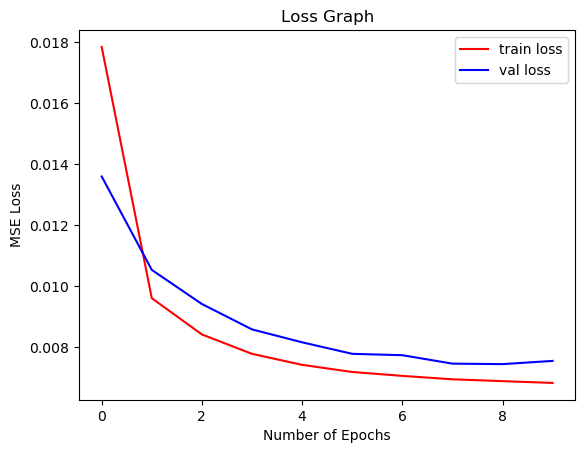

In [120]:
plt.plot(model.history.history['loss'],'r',label='train loss')
plt.plot(model.history.history['val_loss'],'b',label='val loss')
plt.xlabel('Number of Epochs')
plt.ylabel('MSE Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [128]:
scaled_train.shape

(15415, 28)

In [136]:
test_predictions = []

first_eval_batch = scaled_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in tqdm(range(len(test))):
    pred = model.predict(current_batch,verbose=0)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

  0%|          | 0/4320 [00:00<?, ?it/s]

In [137]:
test_predictions = np.array(test_predictions)
test_predictions.shape

(4320, 28)

In [138]:
test_predictions[:10]

array([[ 0.25688455, -0.00973516,  0.5925869 ,  0.20842853,  0.39172357,
         0.3106119 ,  0.35228378,  0.08527387,  0.57921946,  0.23991534,
         0.49231443,  0.10147651,  0.47665092,  0.39362726,  0.5170908 ,
         0.16271998,  0.7227842 ,  0.27909988,  0.4205661 ,  0.07289363,
         0.47810578,  0.5678263 ,  0.4805443 ,  0.19597203,  0.6086408 ,
         0.37498534,  0.5233218 ,  0.52626777],
       [ 0.19425543, -0.00628305,  0.5878447 ,  0.21813262,  0.3881706 ,
         0.3118481 ,  0.34479663,  0.09360052,  0.55339134,  0.23755458,
         0.48706722,  0.12697302,  0.478854  ,  0.3823354 ,  0.50129557,
         0.158756  ,  0.7146703 ,  0.26375443,  0.39606446,  0.08020699,
         0.46983108,  0.55363184,  0.48231208,  0.18441552,  0.63705444,
         0.3682167 ,  0.5128501 ,  0.5194992 ],
       [ 0.15976213, -0.00286375,  0.58770025,  0.22080073,  0.38558155,
         0.31429142,  0.33413136,  0.09867319,  0.52695453,  0.2388497 ,
         0.48054457,  0.1477

In [171]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[ 2.8486646e+02, -6.8146110e-01,  2.1121811e+01, ...,
         1.4973608e-01,  2.6170856e+01,  2.6318125e+01],
       [ 2.1785332e+02, -4.3981358e-01,  2.1087145e+01, ...,
         2.7900480e-02,  2.5647377e+01,  2.5979763e+01],
       [ 1.8094548e+02, -2.0046243e-01,  2.1086088e+01, ...,
        -1.2949562e-02,  2.5504187e+01,  2.5758617e+01],
       ...,
       [ 1.0000000e+01,  0.0000000e+00,  1.6789999e+01, ...,
        -6.6000004e+00,  9.9999998e-03,  9.9999998e-03],
       [ 1.0000000e+01,  0.0000000e+00,  1.6789999e+01, ...,
        -6.6000004e+00,  9.9999998e-03,  9.9999998e-03],
       [ 1.0000000e+01,  0.0000000e+00,  1.6789999e+01, ...,
        -6.6000004e+00,  9.9999998e-03,  9.9999998e-03]], dtype=float32)

In [172]:
true_predictions.shape

(4320, 28)

In [173]:
test.shape

(4320, 28)

In [174]:
test.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-04-27 18:10:00,180,0,21.26,37.43,19.57,35.40,21.29,34.06,20.29,33.76,...,19.1,32.70,7.22,753.87,62.67,3.0,40.0,0.45,4.37,4.37
2016-04-27 18:20:00,100,0,21.43,41.73,19.70,35.83,21.32,34.50,20.29,34.10,...,19.1,32.70,7.43,753.93,62.33,3.0,40.0,0.60,39.44,39.44
2016-04-27 18:30:00,100,10,21.58,39.80,19.76,36.22,21.39,34.90,20.29,34.49,...,19.1,32.70,7.65,754.00,62.00,3.0,40.0,0.75,44.41,44.41
2016-04-27 18:40:00,100,0,21.67,37.53,19.89,36.50,21.50,35.06,20.29,34.73,...,19.1,32.70,7.87,754.07,61.67,3.0,40.0,0.90,27.38,27.38
2016-04-27 18:50:00,140,0,21.73,36.56,19.89,36.43,21.50,35.00,20.29,34.79,...,19.1,33.03,8.08,754.13,61.33,3.0,40.0,1.05,42.75,42.75


In [175]:
true_predictions = pd.DataFrame(true_predictions,columns=test.columns)
true_predictions.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,284.866455,-0.681461,21.121811,35.156307,19.429651,35.162224,20.863752,34.124851,20.116039,33.281216,...,18.654068,32.655529,6.809213,753.716553,64.157555,2.743608,40.561653,0.149736,26.170856,26.318125
1,217.853317,-0.439814,21.087145,35.502064,19.399450,35.199642,20.785885,34.270817,19.892368,33.225903,...,18.434776,32.818615,6.604828,753.106201,64.279533,2.581817,42.408539,0.027900,25.647377,25.979763
2,180.945480,-0.200462,21.086088,35.597130,19.377441,35.273602,20.674967,34.359741,19.663425,33.256248,...,18.274725,32.906559,6.522801,752.695618,64.568954,2.398691,44.492996,-0.012950,25.504187,25.758617
3,158.765762,0.151961,21.102716,35.585800,19.365173,35.324055,20.589661,34.432629,19.461555,33.371273,...,18.132250,33.025452,6.398922,752.324829,65.148064,2.236727,46.584679,-0.009266,25.334036,25.507769
4,144.904037,0.537015,21.130901,35.531281,19.354074,35.366245,20.518814,34.489143,19.280239,33.521572,...,18.003349,33.156311,6.240652,752.008240,65.954224,2.099529,48.686947,0.011817,25.154905,25.278481


In [176]:
pd.date_range('2016-04-27 18:10:00',periods=4320,freq='10T')

DatetimeIndex(['2016-04-27 18:10:00', '2016-04-27 18:20:00',
               '2016-04-27 18:30:00', '2016-04-27 18:40:00',
               '2016-04-27 18:50:00', '2016-04-27 19:00:00',
               '2016-04-27 19:10:00', '2016-04-27 19:20:00',
               '2016-04-27 19:30:00', '2016-04-27 19:40:00',
               ...
               '2016-05-27 16:30:00', '2016-05-27 16:40:00',
               '2016-05-27 16:50:00', '2016-05-27 17:00:00',
               '2016-05-27 17:10:00', '2016-05-27 17:20:00',
               '2016-05-27 17:30:00', '2016-05-27 17:40:00',
               '2016-05-27 17:50:00', '2016-05-27 18:00:00'],
              dtype='datetime64[ns]', length=4320, freq='10T')

In [177]:
true_predictions = true_predictions.set_index(pd.date_range('2016-04-27 18:10:00',periods=4320,freq='10T'))
true_predictions.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
2016-04-27 18:10:00,284.866455,-0.681461,21.121811,35.156307,19.429651,35.162224,20.863752,34.124851,20.116039,33.281216,...,18.654068,32.655529,6.809213,753.716553,64.157555,2.743608,40.561653,0.149736,26.170856,26.318125
2016-04-27 18:20:00,217.853317,-0.439814,21.087145,35.502064,19.399450,35.199642,20.785885,34.270817,19.892368,33.225903,...,18.434776,32.818615,6.604828,753.106201,64.279533,2.581817,42.408539,0.027900,25.647377,25.979763
2016-04-27 18:30:00,180.945480,-0.200462,21.086088,35.597130,19.377441,35.273602,20.674967,34.359741,19.663425,33.256248,...,18.274725,32.906559,6.522801,752.695618,64.568954,2.398691,44.492996,-0.012950,25.504187,25.758617
2016-04-27 18:40:00,158.765762,0.151961,21.102716,35.585800,19.365173,35.324055,20.589661,34.432629,19.461555,33.371273,...,18.132250,33.025452,6.398922,752.324829,65.148064,2.236727,46.584679,-0.009266,25.334036,25.507769
2016-04-27 18:50:00,144.904037,0.537015,21.130901,35.531281,19.354074,35.366245,20.518814,34.489143,19.280239,33.521572,...,18.003349,33.156311,6.240652,752.008240,65.954224,2.099529,48.686947,0.011817,25.154905,25.278481


In [193]:
print("For feature 'lights'")
print("MAE:",mean_absolute_error(test['lights'],true_predictions['lights']))
print("MSE:",mean_squared_error(test['lights'],true_predictions['lights']))
print("RMSE:",np.sqrt(mean_squared_error(test['lights'],true_predictions['lights'])))

For feature 'lights'
MAE: 1.531164077622906e+35
MSE: 3.3461553119918265e+73
RMSE: 5.784596193332623e+36


In [195]:
save_model(model,'appliances_energy_predictor.h5')

In [196]:
load_model('appliances_energy_predictor.h5').summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                15800     
                                                                 
 dense_5 (Dense)             (None, 28)                1428      
                                                                 
Total params: 17,228
Trainable params: 17,228
Non-trainable params: 0
_________________________________________________________________
